# 🎶 Music Genre Embedding & Recommendation Pipeline

This notebook contains the **fully‑working, end‑to‑end code** we discussed. Run each section in order or cherry‑pick parts you need.

## Contents
1. Data preparation & class balancing
2. SpecAugment‑based data augmentation (fixed version)
3. Supervised CNN classifier baseline
4. Autoencoder for dense embeddings
5. Triplet network for discriminative embeddings
6. Evaluation utilities (confusion matrix, MAP@k, similarity heat‑maps)
7. FAISS ANN retrieval demo

> **Prerequisites**  
> • Dataset folders defined in the *Paths* cell  
> • Install deps once:  
> `pip install librosa tqdm faiss-cpu umap-learn scikit-learn matplotlib seaborn tensorflow==2.16.1`


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1️⃣ Imports & global paths  (←— EDIT PATHS IF NEEDED)
import os, random, itertools, json, math, shutil, pickle
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import pairwise, average_precision_score
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# === DATASET LAYOUT ===
META_DIR  = '/content/drive/MyDrive/fma_metadata'
AUDIO_DIR = '/content/drive/MyDrive/fma_medium'
WORK_DIR  = '/content/drive/MyDrive/ai-final'           # scratch / outputs
Path(WORK_DIR).mkdir(parents=True, exist_ok=True)

print('✔️  Paths set – edit if your dataset lives elsewhere')


✔️  Paths set – edit if your dataset lives elsewhere


In [3]:
# 2️⃣ Little helpers
import re
def id_to_path(track_id: int, audio_dir: str = AUDIO_DIR) -> str:
    sid = f"{track_id:06d}"
    return os.path.join(audio_dir, sid[:3], f"{sid}.mp3")

def exists_mp3(track_id: int) -> bool:
    return Path(id_to_path(track_id)).exists()

def set_mpl_style():
    plt.style.use('default')
    plt.rcParams['figure.dpi'] = 110

set_mpl_style()


## 3. Data preparation & class balancing

In [4]:
from pathlib import Path

BALANCED_PATH = Path(WORK_DIR) / 'balanced_filtered_tracks.csv'

TARGET_SIZE = 2000

if BALANCED_PATH.exists():
    print(f'⚡️ Skipping: {BALANCED_PATH} already exists!')
    balanced = pd.read_csv(BALANCED_PATH, index_col=0)
    print('Loaded existing balanced DataFrame.')
    print('Balanced dataset shape:', balanced.shape)
    print(balanced['track.genre_top'].value_counts())
else:
    selected_genres = [
        'Rock', 'Electronic', 'Experimental', 'Hip-Hop',
        'Folk', 'Instrumental', 'Pop', 'International'
    ]

    tracks = pd.read_csv(Path(META_DIR) / 'tracks.csv', header=[0, 1], index_col=0)
    tracks.columns = ['.'.join(col).strip() for col in tracks.columns.values]
    tracks = tracks.dropna(subset=['track.genre_top'])
    tracks = tracks[tracks['track.genre_top'].isin(selected_genres)]
    mask = tracks.index.to_series().apply(exists_mp3)
    tracks = tracks[mask]

    print('After initial filter:', len(tracks))


    balanced_rows = []

    for g, g_df in tracks.groupby('track.genre_top'):
        if len(g_df) >= TARGET_SIZE:
            balanced_rows.append(g_df.sample(n=TARGET_SIZE, random_state=SEED))
        else:
            balanced_rows.append(g_df)   # az olanlar augment edilecek

    balanced = pd.concat(balanced_rows).sort_index()
    balanced.to_csv(BALANCED_PATH)
    print('Balanced dataset shape:', balanced.shape)
    print(balanced['track.genre_top'].value_counts())


⚡️ Skipping: /content/drive/MyDrive/ai-final/balanced_filtered_tracks.csv already exists!
Loaded existing balanced DataFrame.
Balanced dataset shape: (13073, 52)
track.genre_top
Hip-Hop          2000
Experimental     2000
Electronic       2000
Rock             2000
Folk             1519
Instrumental     1350
Pop              1186
International    1018
Name: count, dtype: int64


## 4. SpecAugment – fixed implementation

In [8]:
import numpy as np

def spec_augment(mel, max_f=15, max_t=25):
    """Simple frequency & time masking (in‑place copy)."""
    mel = mel.copy()
    # Frequency mask
    f = np.random.randint(0, max_f)
    f0 = np.random.randint(0, max(1, mel.shape[0] - f))
    mel[f0:f0+f, :] = 0
    # Time mask
    t = np.random.randint(0, max_t)
    t0 = np.random.randint(0, max(1, mel.shape[1] - t))
    mel[:, t0:t0+t] = 0
    return mel


In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

AUG_DIR = Path(WORK_DIR) / 'aug_mels'
AUG_DIR.mkdir(parents=True, exist_ok=True)
AUG_META_PATH = Path(WORK_DIR) / "aug_meta.csv"

minority_genres = ['Folk', 'Instrumental', 'Pop', 'International']
SAMPLE_RATE = 22050
N_MELS = 128
aug_meta = []

for g in minority_genres:
    g_df = balanced[balanced['track.genre_top'] == g]
    needed = TARGET_SIZE - len(g_df)
    if needed <= 0:
        print(f'🔁 {g}: Augmentation not needed (already {len(g_df)})')
        continue
    print(f'🔁 Augmenting {g}: need {needed}')
    for _ in tqdm(range(needed)):
        row = g_df.sample(n=1, random_state=np.random.randint(1e9)).iloc[0]
        track_id = row.name
        out_path = AUG_DIR / f"{track_id:06d}_aug.npy"

        # Dosya zaten varsa atla
        if out_path.exists():
            continue

        try:
            y, sr = librosa.load(id_to_path(track_id), sr=SAMPLE_RATE, mono=True)
            mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=N_MELS)
            logmel = librosa.power_to_db(mel, ref=np.max)
            logmel = spec_augment(logmel)
            logmel = (logmel - logmel.min()) / (logmel.max() - logmel.min() + 1e-6)

            np.save(out_path, logmel.astype(np.float32))

            aug_meta.append({
                'track_id': track_id,
                'genre_top': g,
                'augmented': True,
                'mel_path': str(out_path)
            })
        except Exception as e:
            print('⚠️', e)

# -- Augmented meta güncellemesi --
if AUG_META_PATH.exists():
    aug_df_old = pd.read_csv(AUG_META_PATH, index_col=0)
    if len(aug_meta) > 0:
        aug_df_new = pd.DataFrame(aug_meta).set_index('track_id')
        aug_df = pd.concat([aug_df_old, aug_df_new]).drop_duplicates(keep='first')
    else:
        aug_df = aug_df_old
else:
    if len(aug_meta) > 0:
        aug_df = pd.DataFrame(aug_meta).set_index('track_id')
    else:
        aug_df = pd.DataFrame(columns=["genre_top", "augmented", "mel_path"])

aug_df.to_csv(AUG_META_PATH)
print('Augmented rows (total):', len(aug_df))

# -- Final meta birleştirme --
balanced['augmented'] = False
balanced['mel_path']  = balanced.index.map(lambda tid: None)

final_meta = pd.concat([balanced, aug_df])
final_meta.to_csv(Path(WORK_DIR) / 'final_balanced_tracks.csv')
print('✅ Final meta saved – total rows:', len(final_meta))


🔁 Augmenting Folk: need 481


  0%|          | 0/481 [00:00<?, ?it/s]Exception ignored in: <function _xla_gc_callback at 0x798f76850220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
 29%|██▉       | 139/481 [01:02<04:17,  1.33it/s]<ipython-input-9-79046c22711f>:32: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(id_to_path(track_id), sr=SAMPLE_RATE, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 140/481 [01:03<03:52,  1.46it/s]

⚠️ 


 65%|██████▍   | 311/481 [01:41<00:22,  7.43it/s]<ipython-input-9-79046c22711f>:32: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(id_to_path(track_id), sr=SAMPLE_RATE, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 68%|██████▊   | 325/481 [01:41<00:11, 13.63it/s]

⚠️ 


 94%|█████████▍| 452/481 [01:58<00:04,  6.70it/s]<ipython-input-9-79046c22711f>:32: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(id_to_path(track_id), sr=SAMPLE_RATE, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 95%|█████████▍| 455/481 [01:58<00:03,  7.85it/s]

⚠️ 


100%|██████████| 481/481 [02:04<00:00,  3.88it/s]


🔁 Augmenting Instrumental: need 650


100%|██████████| 650/650 [01:37<00:00,  6.68it/s]


🔁 Augmenting Pop: need 814


 81%|████████  | 661/814 [01:24<00:19,  7.79it/s]


KeyboardInterrupt: 

## 5. Convert all mel‑spectrograms to `.npy` arrays

In [5]:
from pathlib import Path
import numpy as np
from tqdm import tqdm

NPY_DIR = Path(WORK_DIR) / 'npy_data'
NPY_DIR.mkdir(exist_ok=True)

X_PATH = NPY_DIR / 'X_all.npy'
Y_PATH = NPY_DIR / 'y_all.npy'

if X_PATH.exists() and Y_PATH.exists():
    print(f"⚡️ Skipping: {X_PATH.name} and {Y_PATH.name} already exist!")
    X = np.load(X_PATH)
    y = np.load(Y_PATH)
    print('Loaded existing arrays:', X.shape, y.shape)
else:
    X_list, y_list = [], []

    # Eğer daha önce tanımlı değilse final_meta'yı yükle
    # final_meta = pd.read_csv(...)  # Gerekirse ekle!

    final_meta = final_meta.dropna(subset=['track.genre_top'])

    genre_names = sorted(final_meta['track.genre_top'].unique())
    genre_to_idx = {g: i for i, g in enumerate(genre_names)}

    def load_or_compute_mel(tid):
        row = final_meta.loc[tid]
        if 'augmented' in row and row['augmented']:
            return np.load(row['mel_path'])
        # compute on the fly
        y, sr = librosa.load(id_to_path(tid), sr=SAMPLE_RATE, mono=True)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048,
                                             hop_length=512, n_mels=N_MELS)
        logmel = librosa.power_to_db(mel, ref=np.max)
        logmel = (logmel - logmel.min()) / (logmel.max() - logmel.min() + 1e-6)
        return logmel

    skipped = 0

    for tid in tqdm(final_meta.index, desc='Mel→NPY'):
        try:
            mel = load_or_compute_mel(tid)
            mel = librosa.util.fix_length(mel, size=128, axis=1)
            X_list.append(mel[..., np.newaxis])
            y_idx = genre_to_idx[final_meta.loc[tid]['track.genre_top']]
            y_list.append(y_idx)
        except Exception as e:
            print(f"⚠️ {tid}: {e} (skipped)")
            skipped += 1
            continue

    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list)
    np.save(X_PATH, X)
    np.save(Y_PATH, y)

    print('✅ Saved:', X.shape, y.shape)
    print(f"Toplam atlanan sample: {skipped}")


⚡️ Skipping: X_all.npy and y_all.npy already exist!
Loaded existing arrays: (13065, 128, 128, 1) (13065,)


In [ ]:
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

SEED      = 42
TEST_SIZE = 0.10
NPY_DIR   = Path(WORK_DIR) / "npy_data"

# Takip edeceğimiz dosyalar
SPLIT = {
    "X_train": NPY_DIR / "X_train.npy",
    "X_val"  : NPY_DIR / "X_val.npy",
    "y_train": NPY_DIR / "y_train.npy",
    "y_val"  : NPY_DIR / "y_val.npy",
}

# 1) Split dosyaları var mı?
if all(p.exists() for p in SPLIT.values()):
    print("⚡️  Cached splits bulundu, yükleniyor …")
    X_train = np.load(SPLIT["X_train"])
    X_val   = np.load(SPLIT["X_val"])
    y_train = np.load(SPLIT["y_train"])
    y_val   = np.load(SPLIT["y_val"])

# 2) Yoksa X_all / y_all’dan üret
else:
    print("✂️  Split dosyaları yok, X_all.npy ve y_all.npy yükleniyor …")
    X = np.load(NPY_DIR / "X_all.npy")
    y = np.load(NPY_DIR / "y_all.npy")

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
    )

    # Bir sonraki çalıştırma için kaydet
    np.save(SPLIT["X_train"], X_train)
    np.save(SPLIT["X_val"],   X_val)
    np.save(SPLIT["y_train"], y_train)
    np.save(SPLIT["y_val"],   y_val)
    print("✅  Split dosyaları kaydedildi.")

print("Train/val shapes:", X_train.shape, X_val.shape)

# Ensure y_all is loaded to get the full list of genres if it wasn't loaded in the else block
try:
    y_all = y # y was loaded in the else block
except NameError:
    y_all = np.load(NPY_DIR / "y_all.npy") # load y_all if the else block was skipped

# Define genre_names based on all unique labels in y_all
# We need the mapping from integer label back to genre name for this requires the original 'final_meta' DataFrame or saving the genre_to_idx mapping.
# Assuming 'final_meta' is available or can be reloaded:
try:
    final_meta = pd.read_csv(Path(WORK_DIR) / 'final_balanced_tracks.csv', index_col=0)
    genre_names = sorted(final_meta['track.genre_top'].unique().tolist())
    # Create a mapping from index to genre name for later use
    idx_to_genre = {i: g for i, g in enumerate(genre_names)}
except FileNotFoundError:
    print("Error: final_balanced_tracks.csv not found. Cannot determine genre names.")
    # Fallback: if you absolutely know the genre names and their order corresponding to the integer labels
    # genre_names = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] # VERIFY ORDER
    # idx_to_genre = {i: g for i, g in enumerate(genre_names)}


# ── one-hot encode ────────────────────────────────────────────────
lb = LabelBinarizer()
# Need to fit on ALL unique classes to ensure consistency,
# even if a class doesn't appear in train/val split (less likely with stratify, but good practice)
# Using y_all to fit the binarizer ensures all possible genres are considered.
lb.fit(y_all)
y_train_oh = lb.transform(y_train)
y_val_oh   = lb.transform(y_val)
print("One-hot shapes :", y_train_oh.shape, y_val_oh.shape)

# Update the genre_names definition here to use the fitted classes from the binarizer,
# which is a more robust way to get the ordered genre names corresponding to the indices.
# However, lb.classes_ gives the labels in the order they appear after fitting.
# If fitting on y_all, it should match the sorted unique list. Let's stick to the sorted unique
# from final_meta as it was the original approach and is used in the confusion matrix cell.
# If final_meta cannot be loaded, use lb.classes_ as a fallback:
if 'genre_names' not in locals():
    print("Using LabelBinarizer classes for genre names (fallback).")
    genre_names = lb.classes_.tolist() # This order might differ from sorted

⚡️  Cached splits bulundu, yükleniyor …
Train/val shapes: (11758, 128, 128, 1) (1307, 128, 128, 1)
One-hot shapes : (11758, 8) (1307, 8)


## 6. Supervised CNN classifier (improved)

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import math
from pathlib import Path

# --- CONFIG --------------------------------------------------
NUM_CLASSES = 8
INPUT_SHAPE = (128, 128, 1)
BATCH_SIZE = 16
BASE_LR = 1e-4

# --- SpecAugment ---------------------------------------------
class SpecAugment(layers.Layer):
    def __init__(self, max_f=25, max_t=40, **kw):
        super().__init__(**kw)
        self.max_f, self.max_t = max_f, max_t
        self.h, self.w = 128, 128
        self.freq_axis = tf.reshape(tf.range(self.h), (self.h, 1, 1))
        self.time_axis = tf.reshape(tf.range(self.w), (1, self.w, 1))

    def call(self, x, training=None):
        if not training:
            return x
        f  = tf.random.uniform([], 0, self.max_f + 1, tf.int32)
        f0 = tf.random.uniform([], 0, self.h - f + 1, tf.int32)
        t  = tf.random.uniform([], 0, self.max_t + 1, tf.int32)
        t0 = tf.random.uniform([], 0, self.w - t + 1, tf.int32)
        mask_f = tf.cast(~tf.logical_and(self.freq_axis >= f0,
                                         self.freq_axis < f0 + f), x.dtype)
        mask_t = tf.cast(~tf.logical_and(self.time_axis >= t0,
                                         self.time_axis < t0 + t), x.dtype)
        return x * mask_f * mask_t

# --- GroupNorm -------------------------------------------------
class GroupNorm(layers.Layer):
    def __init__(self, groups=8, epsilon=1e-5, **kw):
        super().__init__(**kw)
        self.groups, self.eps = groups, epsilon

    def build(self, inp_shape):
        self.gamma = self.add_weight(name="gamma", shape=(inp_shape[-1],),
                                     initializer="ones", trainable=True)
        self.beta  = self.add_weight(name="beta", shape=(inp_shape[-1],),
                                     initializer="zeros", trainable=True)

    def call(self, x):
        N, H, W, C = tf.shape(x)[0], *x.shape[1:]
        G = self.groups
        x = tf.reshape(x, [N, H, W, G, C // G])
        mean, var = tf.nn.moments(x, [1, 2, 4], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.eps)
        x = tf.reshape(x, [N, H, W, C])
        return x * self.gamma + self.beta

# --- Focal Loss -----------------------------------------------
def focal_loss(alpha=0.25, gamma=2.0):
    def _loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce  = -y_true * tf.math.log(y_pred)
        fl  = alpha * tf.pow(1 - y_pred, gamma) * ce
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return _loss

# --- Optimized CNN Model ---------------------------------------
def build_optimized_cnn():
    inp = layers.Input(shape=INPUT_SHAPE)
    x = SpecAugment(max_f=25, max_t=40)(inp)

    for f in [32, 64, 128, 256, 256]:
        x = layers.Conv2D(f, 3, padding='same', activation='relu')(x)
        x = GroupNorm(groups=8)(x)
        x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return models.Model(inp, out)

# --- Data Pipeline (without Mixup for simplicity) --------------
def create_dataset(X, y, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# --- Training Setup --------------------------------------------
model = build_optimized_cnn()
optimizer = tf.keras.optimizers.Adam(BASE_LR)
loss_fn = focal_loss(alpha=0.25, gamma=2.0)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
model.summary()

# --- Callbacks -------------------------------------------------
cb_early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
cb_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1, monitor='val_loss')

# --- Example Training Call -------------------------------------
train_ds = create_dataset(X_train, y_train_oh, BATCH_SIZE)
val_ds = create_dataset(X_val, y_val_oh, BATCH_SIZE)

hist = model.fit(train_ds,
                 epochs=100,
                 validation_data=val_ds,
                 callbacks=[cb_early, cb_lr])

Path("models").mkdir(exist_ok=True)
model.save("models/optimized_cnn_model.keras")

print("✅ Eğitim tamamlandı, model kaydedildi.")


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spec_augment_21 (SpecAugment)   │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_272 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm_179 (GroupNorm)      │ (None, 128, 128, 32)   │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_113               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_273 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm_180 (GroupNorm)      │ (None, 64, 64, 64)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_114               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_274 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm_181 (GroupNorm)      │ (None, 32, 32, 128)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_115               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_275 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm_182 (GroupNorm)      │ (None, 16, 16, 256)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_116               │ (None, 8, 8, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_276 (Conv2D)             │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm_183 (GroupNorm)      │ (None, 8, 8, 256)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 4, 4, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_39     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,760 (4.77 MB)

 Trainable params: 1,250,760 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.2364 - loss: 0.4221 - val_accuracy: 0.3356 - val_loss: 0.3604 - learning_rate: 1.0000e-04
Epoch 2/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3438 - loss: 0.3389 - val_accuracy: 0.4187 - val_loss: 0.3036 - learning_rate: 1.0000e-04
Epoch 3/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3816 - loss: 0.3199 - val_accuracy: 0.4474 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 4/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4177 - loss: 0.3053 - val_accuracy: 0.4225 - val_loss: 0.3037 - learning_rate: 1.0000e-04
Epoch 5/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4448 - loss: 0.2925 - val_accuracy: 0.4160 - val_loss: 0.2917 - learning_rate: 1.0000e-04
Epoch 6/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4628 - loss: 0.2824 - val_accuracy: 0.4979 - val_loss: 0.2627 - learning_rate: 1.0000e-04
Epoch 7/100
654/654 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/st

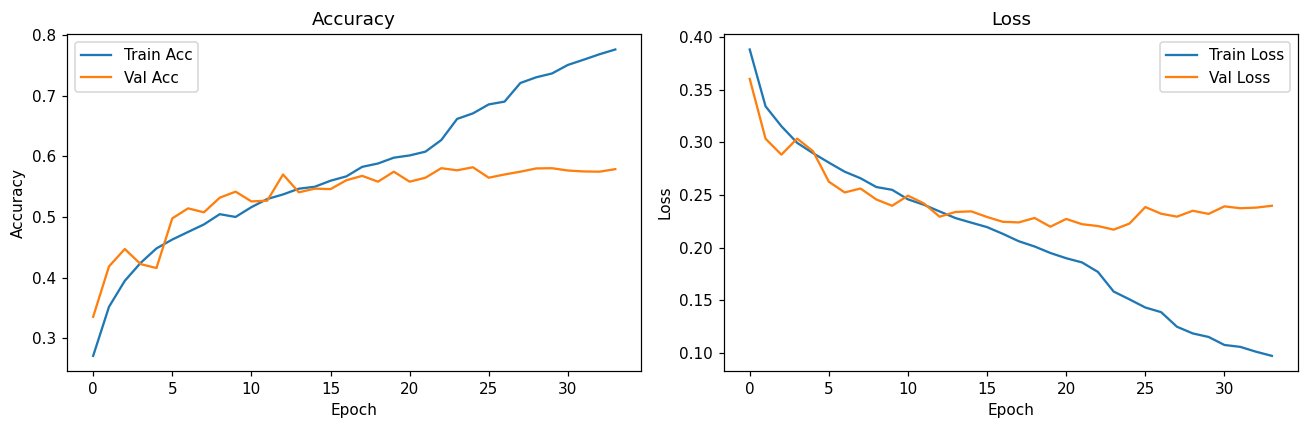

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


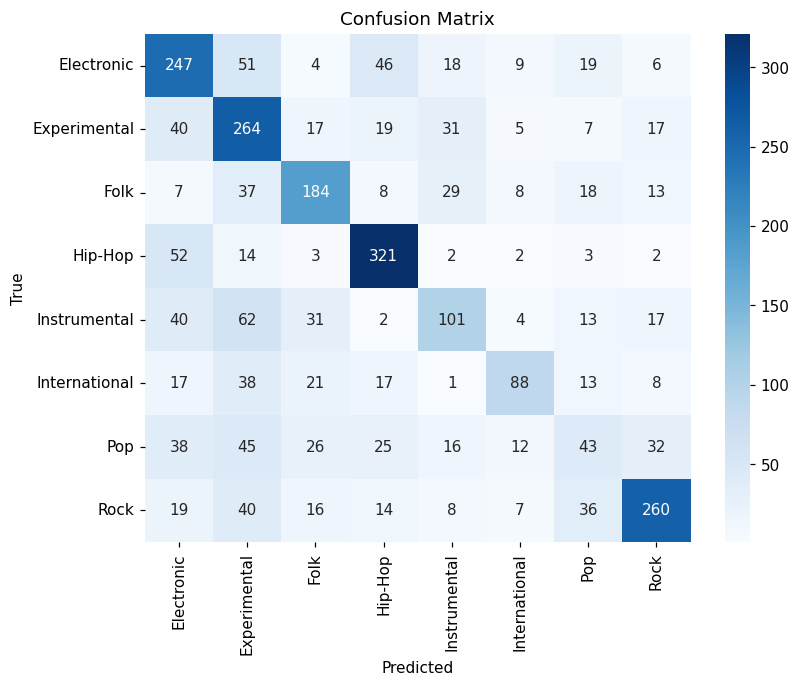


Classification Report:
               precision    recall  f1-score   support

   Electronic       0.54      0.62      0.57       400
 Experimental       0.48      0.66      0.56       400
         Folk       0.61      0.61      0.61       304
      Hip-Hop       0.71      0.80      0.75       399
 Instrumental       0.49      0.37      0.42       270
International       0.65      0.43      0.52       203
          Pop       0.28      0.18      0.22       237
         Rock       0.73      0.65      0.69       400

     accuracy                           0.58      2613
    macro avg       0.56      0.54      0.54      2613
 weighted avg       0.57      0.58      0.57      2613

✅ Training completed, model saved and evaluated.

Final validation accuracy: 0.5790
Best validation accuracy: 0.5821


In [39]:
# --- Visualize Training History -----------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='Train Acc')
plt.plot(hist.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- Confusion Matrix & Classification Report ---------------
y_pred = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=genre_names, yticklabels=genre_names)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report with performance metrics by class
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=genre_names))

print("✅ Training completed, model saved and evaluated.")

# --- Final Performance Metrics -----------------------------
val_accuracy = hist.history['val_accuracy'][-1]
print(f"\nFinal validation accuracy: {val_accuracy:.4f}")
print(f"Best validation accuracy: {max(hist.history['val_accuracy']):.4f}")

## 7. Autoencoder embeddings

In [ ]:
LATENT = 64

def build_autoencoder(input_shape=(128,128,1), latent_dim=LATENT):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    emb = layers.Dense(latent_dim, name='embedding')(x)

    # Decoder (upsample → conv to avoid checkerboard)
    x = layers.Dense(32*32*2, activation='relu')(emb)
    x = layers.Reshape((32,32,2))(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    # Corrected output layer: reconstructs to 1 channel with sigmoid activation
    out = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

    auto = models.Model(inp, out)
    enc  = models.Model(inp, emb)
    return auto, enc

auto, encoder = build_autoencoder()
auto.compile(optimizer='adam', loss='mse')

h = auto.fit(X_train, X_train, epochs=30, batch_size=64,
             validation_split=0.1,
             callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - loss: 0.0237 - val_loss: 0.0115
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 9/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 10/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 11/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 12/30
166/166 ━━━━━━━━━

In [ ]:
# Save encoder & embeddings
ENC_DIR = Path(WORK_DIR) / 'encoder'
ENC_DIR.mkdir(exist_ok=True)
encoder.save(ENC_DIR / 'auto_encoder.keras')

embeddings_auto = encoder.predict(X)
np.save(ENC_DIR / 'embeddings_auto.npy', embeddings_auto)
print('Autoencoder embeddings shape:', embeddings_auto.shape)


409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Autoencoder embeddings shape: (13065, 64)


## 8. Triplet network embeddings

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from pathlib import Path
import numpy as np

# ---------------- HİPER-PARAMETRELER ---------------- #
LATENT_DIM   = 64
MARGIN       = 0.2
BATCH        = 64
EPOCHS       = 20
STEPS_PER_EP = 2_000
VAL_STEPS    = 100
SEED         = 42

# ---------------- TRIPLET LOSS ----------------------- #
def triplet_loss(margin=MARGIN):
    def _loss(_, y_pred):
        a, p, n = tf.split(y_pred, 3, axis=1)         # (batch, 64)
        pos_d   = tf.reduce_sum(tf.square(a - p), 1)  # axis=1!
        neg_d   = tf.reduce_sum(tf.square(a - n), 1)
        return tf.reduce_mean(tf.maximum(pos_d - neg_d + margin, 0.0))
    return _loss

# ---------------- BASE ENCODER ----------------------- #
def build_base_encoder(input_shape=(128,128,1), emb_dim=LATENT_DIM):
    inp = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)          # 64×64

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)          # 32×32

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)             # parametre sayısını düşürür
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(emb_dim)(x)
    
    # Use a standalone function that captures tf, instead of a lambda that doesn't capture
    def l2_normalize(t):
        import tensorflow as tf  # Import inside the function
        return tf.math.l2_normalize(t, axis=1)
    
    out = layers.Lambda(l2_normalize, output_shape=(emb_dim,))(x)
    
    return models.Model(inp, out, name="base_encoder")

# ---------------- TRIPLET MODEL ---------------------- #
def build_triplet_model(input_shape=(128,128,1)):
    base = build_base_encoder(input_shape)
    ia, ip, ineg = [layers.Input(shape=input_shape) for _ in range(3)]
    ea, ep, en   = base(ia), base(ip), base(ineg)
    merged       = layers.Concatenate(axis=1)([ea, ep, en])
    return models.Model([ia, ip, ineg], merged, name="triplet_model"), base

triplet_model, base_encoder = build_triplet_model()
triplet_model.compile(optimizer='adam', loss=triplet_loss())

# ---------------- TRIPLET SAMPLER -------------------- #
def make_triplet_ds(X_np, y_np, batch_size=BATCH, steps_per_epoch=STEPS_PER_EP, seed=SEED):
    X  = tf.convert_to_tensor(X_np, tf.float32)
    y  = tf.convert_to_tensor(y_np, tf.int32)
    ns = X.shape[0]

    def sample(_):
        idx  = tf.random.uniform([], 0, ns, tf.int32)
        anc  = X[idx]; lab = y[idx]
        pos_pool = tf.where(tf.equal(y, lab))[:,0]
        neg_pool = tf.where(tf.not_equal(y, lab))[:,0]
        pos = X[pos_pool[ tf.random.uniform([], 0, tf.shape(pos_pool)[0], tf.int32) ]]
        neg = X[neg_pool[ tf.random.uniform([], 0, tf.shape(neg_pool)[0], tf.int32) ]]
        return (anc, pos, neg), tf.zeros((1,), tf.float32)

    ds = (tf.data.Dataset.range(steps_per_epoch*batch_size, name="triplet_rng")
          .map(sample, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size).prefetch(tf.data.AUTOTUNE))
    return ds

train_ds = make_triplet_ds(X_train, y_train)
val_ds   = make_triplet_ds(X_val,   y_val, steps_per_epoch=VAL_STEPS)

# ---------------- CALLBACK'LER ----------------------- #
cb_early = callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss')
cb_lr    = callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1, monitor='val_loss')

# ---------------- EĞİT -------------------------------- #
history = triplet_model.fit(
    train_ds,
    epochs           = EPOCHS,
    steps_per_epoch  = STEPS_PER_EP,
    validation_data  = val_ds,
    validation_steps = VAL_STEPS,
    callbacks        = [cb_early, cb_lr]
)

# --------------- EMBEDDING KAYDET -------------------- #
embeddings = base_encoder.predict(X_train, batch_size=128)
Path("embeddings").mkdir(exist_ok=True)
np.save("embeddings/train_triplet_embeddings.npy", embeddings)

# Save model to models directory with unsafe serialization
Path("models").mkdir(exist_ok=True)
# Option 1: Use TF serialization
base_encoder.save("models/base_encoder.keras")

# Option 2: Add a custom object wrapper (optional)
class L2Normalize(tf.keras.layers.Layer):
    def call(self, x):
        return tf.math.l2_normalize(x, axis=1)
        
    def get_config(self):
        return super().get_config()

# Register the custom class for serialization
tf.keras.utils.register_keras_serializable()(L2Normalize)

print("✅ Training complete – embeddings saved.")

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 177s 84ms/step - loss: 0.2297 - val_loss: 0.1390 - learning_rate: 0.0010
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 167s 84ms/step - loss: 0.1395 - val_loss: 0.1405 - learning_rate: 0.0010
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1313
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 167s 83ms/step - loss: 0.1313 - val_loss: 0.1480 - learning_rate: 0.0010
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 167s 83ms/step - loss: 0.1237 - val_loss: 0.1283 - learning_rate: 5.0000e-04
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 167s 83ms/step - loss: 0.1177 - val_loss: 0.1266 - learning_rate: 5.0000e-04
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 166s 83ms/step - loss: 0.1135 - val_loss: 0.1242 - learning_rate: 5.0000e-04
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 167s 83ms/step - loss: 0.1079 - val_loss: 0.1363 - learning_rate: 5.0000e-04
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
def map_at_k(embeddings, labels, k=10):
    sims = pairwise.cosine_similarity(embeddings)
    np.fill_diagonal(sims, -np.inf)   # exclude self
    idx = np.argsort(sims, axis=1)[:, ::-1][:, :k]
    hits = (labels[idx] == labels[:, None])
    apk = hits.cumsum(axis=1) / (np.arange(k) + 1)
    mapk = (apk * hits).sum(axis=1) / hits.sum(axis=1).clip(min=1)
    return mapk.mean()

print('MAP@10 (autoencoder):',
      map_at_k(embeddings_auto, y))
print('MAP@10 (triplet):',
      map_at_k(triplet_embeddings, y))


MAP@10 (autoencoder): 0.3736857674098256
MAP@10 (triplet): 0.6287587486044014


In [ ]:
!pip -q install faiss-cpu
import faiss

# L2‑normalise for cosine → inner‑product trick
vecs = triplet_embeddings.astype('float32')
faiss.normalize_L2(vecs)

index = faiss.IndexFlatIP(vecs.shape[1])
index.add(vecs)

def query(track_idx, top_k=5):
    q = vecs[track_idx:track_idx+1]
    D, I = index.search(q, top_k+1)  # +1 for itself
    I = I[0][1:]  # drop self
    print('Query genre:', genre_names[y[track_idx]])
    for rank, i in enumerate(I, 1):
        print(f'{rank:>2}. id={i} genre={genre_names[y[i]]}  score={D[0][rank]:.3f}')

query(1234, top_k=5)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 61.6 MB/s eta 0:00:00
Query genre: Hip-Hop
 1. id=6355 genre=Hip-Hop  score=0.996
 2. id=7972 genre=Hip-Hop  score=0.996
 3. id=6637 genre=Hip-Hop  score=0.995
 4. id=4866 genre=Hip-Hop  score=0.995
 5. id=12022 genre=Hip-Hop  score=0.995


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


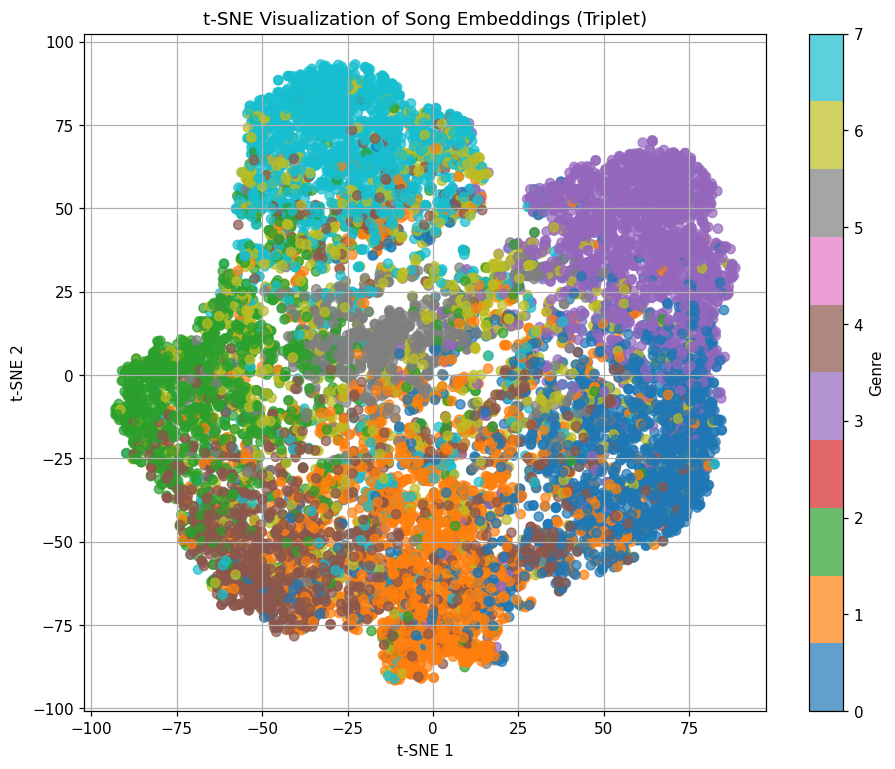

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Embedding ve etiketleri yükle
embeddings = np.load(str(Path(WORK_DIR) / 'triplet_embeddings.npy'))  # veya 'embeddings_auto.npy'
y = np.load(str(NPY_DIR / 'y_all.npy'))
genre_names = sorted(np.unique(y))

# t-SNE ile 2D'ye indir
tsne = TSNE(n_components=2, perplexity=30, n_iter=1500, random_state=SEED)
reduced = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.title("t-SNE Visualization of Song Embeddings (Triplet)")
plt.colorbar(scatter, ticks=range(len(genre_names)), label='Genre')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()


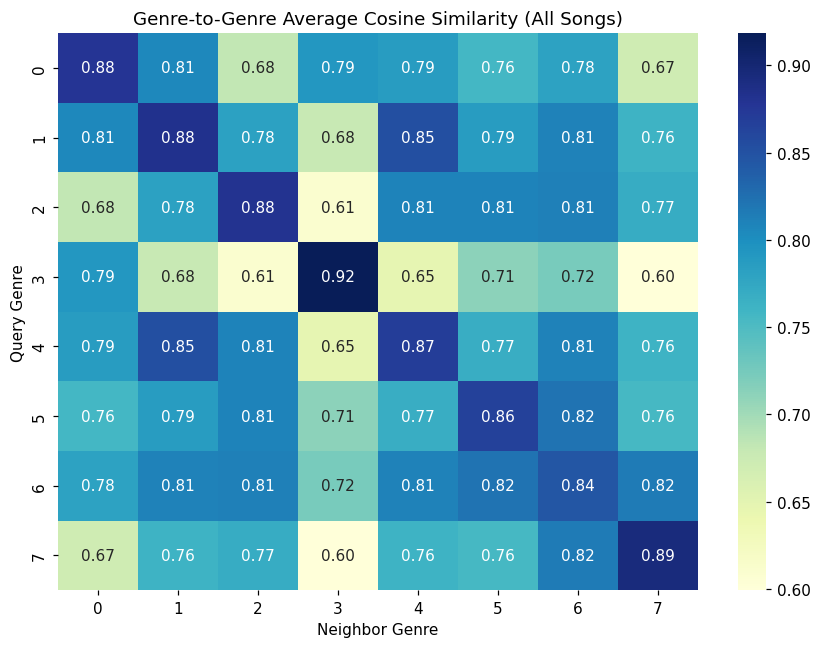

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

sim_matrix = cosine_similarity(embeddings)
n_genres = len(np.unique(y))
genre_sim = np.zeros((n_genres, n_genres))
genre_counts = np.zeros((n_genres, n_genres))

for i in range(len(y)):
    for j in range(len(y)):
        genre_sim[y[i], y[j]] += sim_matrix[i, j]
        genre_counts[y[i], y[j]] += 1

genre_avg_sim = genre_sim / np.maximum(genre_counts, 1)
plt.figure(figsize=(8, 6))
sns.heatmap(genre_avg_sim, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=genre_names, yticklabels=genre_names)
plt.title("Genre-to-Genre Average Cosine Similarity (All Songs)")
plt.xlabel("Neighbor Genre")
plt.ylabel("Query Genre")
plt.tight_layout()
plt.show()


In [ ]:
def retrieval_genre_match(embeddings, y, top_k=5):
    sims = cosine_similarity(embeddings)
    np.fill_diagonal(sims, -np.inf)
    idx = np.argsort(sims, axis=1)[:, ::-1][:, :top_k]
    # Sorgu ile ilk k komşunun türü aynı mı?
    matches = (y[idx] == y[:, None])
    match_rate = matches.sum() / matches.size
    print(f"Top-{top_k} retrieval genre match rate: %{match_rate*100:.2f}")

retrieval_genre_match(embeddings, y, top_k=5)


Top-5 retrieval genre match rate: %55.13


In [ ]:
import pandas as pd

def recommend_from_index(idx, embeddings, y, meta_path, top_k=5):
    meta = pd.read_csv(meta_path, index_col=0)
    sims = cosine_similarity(embeddings[idx:idx+1], embeddings)[0]
    top_indices = np.argsort(sims)[::-1][1:top_k+1]
    recs = []
    for rank, i in enumerate(top_indices, 1):
        recs.append({
            "Rank": rank,
            "Track ID": meta.index[i],
            "True Genre": meta.iloc[i]['track.genre_top'],
            "Similarity": f"{sims[i]:.4f}"
        })
    df = pd.DataFrame(recs)
    print("Query Genre:", meta.iloc[idx]['track.genre_top'])
    display(df)

recommend_from_index(502, embeddings, y, str(Path(WORK_DIR) / 'final_balanced_tracks.csv'), top_k=5)


Query Genre: Hip-Hop


,Rank,Track ID,True Genre,Similarity
0,1,70914,Hip-Hop,0.9915
1,2,147774,Rock,0.9914
2,3,110734,Hip-Hop,0.9903
3,4,110742,Hip-Hop,0.9902
4,5,14380,Hip-Hop,0.9901


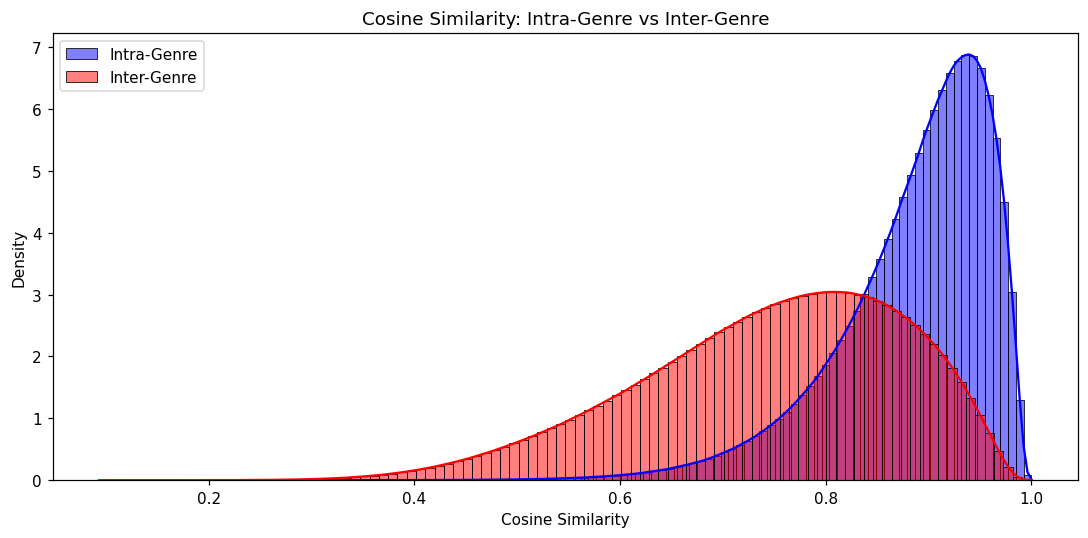

Mean Intra-Genre: 0.886
Mean Inter-Genre: 0.747


In [ ]:
from itertools import combinations

intra_sims, inter_sims = [], []
for i, j in combinations(range(len(y)), 2):
    sim = sim_matrix[i, j]
    if y[i] == y[j]:
        intra_sims.append(sim)
    else:
        inter_sims.append(sim)

plt.figure(figsize=(10, 5))
sns.histplot(intra_sims, color='blue', label='Intra-Genre', stat="density", bins=100, kde=True)
sns.histplot(inter_sims, color='red', label='Inter-Genre', stat="density", bins=100, kde=True)
plt.title("Cosine Similarity: Intra-Genre vs Inter-Genre")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Mean Intra-Genre: {np.mean(intra_sims):.3f}")
print(f"Mean Inter-Genre: {np.mean(inter_sims):.3f}")


*Notebook generated: 2025-05-15T18:05:21.736425Z*